# Load, Create, Train, Evaluate

In this jupyter notebook, I'm trying to create a guidline to load a dataset, create a neural network model, train the model, and evaluate it.

The problem we want to tackle is a two class classification problem and each data sample is an image with a 0 or 1 class label. Thus the dataset directory's structure is as follows:

```
train dataset:
 |
 |___ class_0:
      |
      |___ img0.png
      |___ img7.png
      ...
 |___ class_1:
      |
      |___ img14.png
      |___ img23.png
 |___ metadata.txt
      ...
```
`metadata.txt` includes the maximum width and height of the training dataset.

## Loading the Dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

AUTOTUNE = tf.data.experimental.AUTOTUNE

List all directory and files inside the destination path:

In [2]:
import pathlib

# Destination path
DST_PATH = "./gen_dataset_1000_samples_2_classes"

data_root = pathlib.Path(DST_PATH)

# list all directories and files inside DST_PATH
for item in data_root.iterdir():
    print(item)

gen_dataset_1000_samples_2_classes/class_1
gen_dataset_1000_samples_2_classes/metadata.txt
gen_dataset_1000_samples_2_classes/class_0
gen_dataset_1000_samples_2_classes/.metadata.txt.un~


List of all image paths inside the dataset, shuffling them, printing the total number of images inside the training datset:

In [3]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print("Total number of images is %d" % image_count)
all_image_paths[:5]

Total number of images is 1000


['gen_dataset_1000_samples_2_classes/class_0/img489.png',
 'gen_dataset_1000_samples_2_classes/class_1/img730.png',
 'gen_dataset_1000_samples_2_classes/class_1/img452.png',
 'gen_dataset_1000_samples_2_classes/class_1/img385.png',
 'gen_dataset_1000_samples_2_classes/class_1/img257.png']

Showing a few samples inside the dataset:

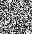

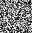

In [4]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))

Now, let's create labels for samples:

First, let's find out how many class do we have and what are the names?

In [5]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['class_0', 'class_1']

Assigning a number to each class by creating a dictionary:

In [6]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'class_0': 0, 'class_1': 1}

list `all_image_paths` shows the path for each image in the dataset. `.parent.name` gives us the outer directory for a particular sample which is the class name. Then we map class name to a label by looking at dictionary `label_to_index`:

In [7]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 1, 1, 1, 1, 1, 0, 0, 0, 1]


Before loading the images, let's know what is the maximum width and height of all the images in the dataset. We need to read the contents of the `metadata.txt` file.

In [8]:
f = open(DST_PATH + "/metadata.txt")
MAX_W = int(next(f).split()[0])
MAX_H = int(next(f).split()[0])
f.close()
print("Max width and height are: [%d, %d]" % (MAX_W, MAX_H))

Max width and height are: [34, 34]


We need also to apply some preprocessing to the images. The `preprocess_image()` does this. In the future, we'd need to modify only this function to apply any preprocessing techniques on the images. No change needs to be done in other places.

In [9]:
def preprocess_image(image):
    # This function gets a string array of pixel values and 
    # returns an image (MAX_W,MAX_H,1) matrix as an image.
    
    # decode a string to the image
    image = tf.image.decode_jpeg(image, channels=3) 
    # resize (padding) all the images to [MAX_W, MAX_H]
    image = tf.image.resize_image_with_crop_or_pad(image, MAX_H, MAX_W)
    # convert image pixel type from uint8 to float32
    image = tf.cast(image, tf.float32)
    image /= 255.0  # normalize to [0,1] range

    return image

`load_and_preprocess_image()` function gets a `path` to the image file, loads that image, and returns a preprocessed image matrix:

In [10]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

Let's try the previous functions. Again, `all_image_paths` is an array including the path to all the images, `all_image_labels` is another array including the label for the corresponding image.

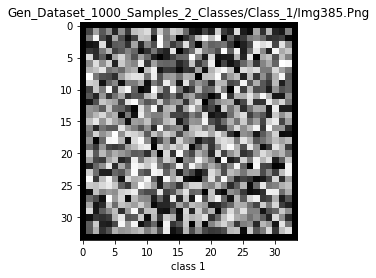

In [12]:
import matplotlib.pyplot as plt

img_path = all_image_paths[3]
label = all_image_labels[3]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel("class %d" % label)
plt.title(img_path.title())
print()

## Build a tf.data.Dataset

Now, that we have a load, and preprocess function, we can create a `tf.data.Dataset` class. This class provide a few functionalities to facilitate and accelerate the training process. You'll see the benefits later on.

In [13]:
# create a tf.data.Dataset object for all_image_paths
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [14]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>
<DatasetV1Adapter shapes: (), types: tf.string>


The following line applies the load_and_preprocess_image on every image path inside the `path_ds` which is a `tf.data.Dataset` object including `all_image_paths`. Think of `tf.data.Dataset` as another representation of an array. Conceptually, it's nothing more than an array, however, facilitates the trainign for us.

In [15]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


Now, let's play with the `image_ds` a little bit:

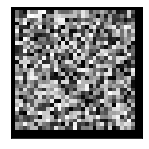

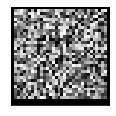

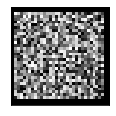

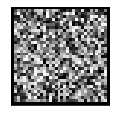

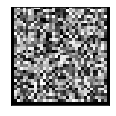

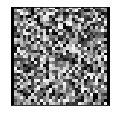

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
# showing 6 images from the dataset:
for n,image in enumerate(image_ds.take(6)):
  plt.subplot(2,3,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  #plt.xlabel()
  plt.show()
# Please note the paddings for the images.

Now, let's create another `tf.data.Dataset` for the labels:

In [17]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [34]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

yes
no
yes
yes
yes
yes
yes
yes
yes
yes


Since the datasets are in the same order you can just zip them together to get a dataset of `(image, label)` pairs:

In [18]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<DatasetV1Adapter shapes: ((34, 34, 3), ()), types: (tf.float32, tf.int64)>


## Basic methods for training

To train a model with this dataset you will want the data:
* To be well shuffled: it means you need to randomly shuffle the order of the samples.
* To be batched: it means you need to create a groupd of samples (batch) and then run the gradient descent (or any other optimization) algorithm on the batch instead of on one single sample.
* To repeat forever.
* To have batches available as soon as possible: It's for accelerating the fetching the samples from disk to the memory. It pre-fetches the next batch to be ready for the process.
These features can be easily added using the `tf.data` api:

In [29]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 34, 34, 3), (?,)), types: (tf.float32, tf.int64)>

## Creating a Neural Network Model
This model is a trivial convolutional neural network model and is just for the demonstration. You need to create a proper model.

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=2, kernel_size=3, strides=(1,1), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Flatten(input_shape=(MAX_W,MAX_H,2)),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

## Compile the model
For more information please see this [link](https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_classification.ipynb#scrollTo=gut8A_7rCaW6)

In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# here you need to determine the number of steps per epoch. Which is:
steps_per_epoch = int(tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy())
steps_per_epoch

32

## Train the model

In [40]:
model.fit(ds, epochs=2, steps_per_epoch=steps_per_epoch)

Epoch 1/2
32/32 [==============================] - 3s 86ms/step
Epoch 2/2
32/32 [==============================] - 1s 23ms/step


The rest of the program is similar to [here](https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_classification.ipynb#scrollTo=qKF6uW-BCaW-) which we discussed before.